In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel

In [3]:
import os
import requests
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import spacy 
from spacy import displacy

In [4]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


In [6]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [6]:
df_sentiment = pd.read_parquet('Sentiment_final.parquet')

In [34]:
df_sentiment.head(2)

date                                     clean_title_v3  \
0 2020-02-26  LegalTech Artificial Intelligence Market  Tech...   
2 2020-03-13  Covid un messaggio dai ricercatori italiani ai...   

                                       clean_text_v5  \
0  LegalTech Artificial Intelligence Market Techn...   
2  Covid un messaggio dai ricercatori italiani ai...   

                                    clean_text_no_ai  sentiment_model  \
0  legaltech  market  advancement future scope ca...                1   
2  covid un messaggio d ricercatori italiani  col...                0   

  sentiment_model_cat                                    sentiment_vader  \
0            Positive  {'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...   
2            Negative  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

   neg_vader  neu_vader  pos_vader  comp_vader  
0        0.0      0.838      0.162         0.0  
2        0.0      1.000      0.000         0.0

In [7]:
nlp = spacy.load("en_core_web_md")

persons = []
organizations = []
locations = []

for doc in nlp.pipe(df_sentiment['clean_text_v5'], batch_size=50, n_process=4, disable=["parser", "tagger"]):
    persons.append([ent.text for ent in doc.ents if ent.label_ == "PERSON"])
    organizations.append([ent.text for ent in doc.ents if ent.label_ == "ORG"])
    locations.append([ent.text for ent in doc.ents if ent.label_ == "GPE"])

df_sentiment['Persons'] = [', '.join(person) for person in persons]
df_sentiment['Organizations'] = [', '.join(org) for org in organizations]
df_sentiment['locations'] = [', '.join(loc) for loc in locations]

In [8]:
df_sentiment.head(2)

date                                     clean_title_v3  \
0  2020-02-26  LegalTech Artificial Intelligence Market  Tech...   
2  2020-03-13  Covid un messaggio dai ricercatori italiani ai...   

                                       clean_text_v5  \
0  LegalTech Artificial Intelligence Market Techn...   
2  Covid un messaggio dai ricercatori italiani ai...   

                                    clean_text_no_ai  sentiment_model_text  \
0  legaltech  market  advancement future scope ca...                     1   
2  covid un messaggio d ricercatori italiani  col...                     1   

  sentiment_model_cat_text  sentiment_model sentiment_model_cat  \
0                 Positive                1            Positive   
2                 Positive                0            Negative   

                                             Persons  \
0  Australis Galus, Agrident AllflexContact, UsIr...   
2  dai ricercatori italiani ai, Di la tua Tempo, ...   

                                       Organizations  \
0  LegalTech, Sony, Roche Diagnostics Veterinary ...   
2  stranieri AgoraVox Italia Accedi Partecipa, Ag...   

                                           locations  
0  Australis, US, United States, China, Japan, In...  
2  Italy, Italy, Italy, Peoples Republic China Fi...

In [9]:
df_sentiment.to_parquet('sentiment_ner.parquet')

In [9]:
df_sentiment = pd.read_parquet('sentiment_ner.parquet')

In [8]:
from collections import Counter

all_persons = [person for sublist in df_sentiment['Persons'].str.split(', ').tolist() for person in sublist if person]
person_counts = Counter(all_persons)
top_10_persons = person_counts.most_common(10)

print(top_10_persons)

[('Sam Altman', 10814), ('Biden', 8880), ('Elon Musk', 7334), ('Altman', 5219), ('ChatGPT', 4845), ('Joe Biden', 4679), ('Bard', 4647), ('Musk', 4106), ('Taylor Swift', 3966), ('Trump', 3457)]


In [9]:
all_organizations = [org for sublist in df_sentiment['Organizations'].str.split(', ').tolist() for org in sublist if org]
organization_counts = Counter(all_organizations)
top_10_organizations = organization_counts.most_common(10)

print(top_10_organizations)

[('AI', 249639), ('Gray Media Group', 61160), ('Google', 42427), ('Microsoft', 39698), ('Gray Television Inc', 37410), ('IBM', 19569), ('Amazon', 19386), ('intelligenceA Gray Media Group Inc Station', 17902), ('AIgenerated', 16205), ('ChatGPT', 14364)]


In [14]:
all_locations = [location for sublist in df_sentiment['locations'].str.split(', ').tolist() for location in sublist if location]
location_counts = Counter(all_locations)
top_10_locations = location_counts.most_common(10)

print(top_10_locations)

[('US', 222672), ('India', 42507), ('China', 39374), ('UK', 36691), ('Canada', 22182), ('France', 21274), ('Japan', 18711), ('Russia', 17945), ('Texas', 17201), ('California', 15724)]


In [12]:
df_pos = df_sentiment[df_sentiment['sentiment_model_cat_text']=='Positive']
df_neg = df_sentiment[df_sentiment['sentiment_model_cat_text']=='Negative']

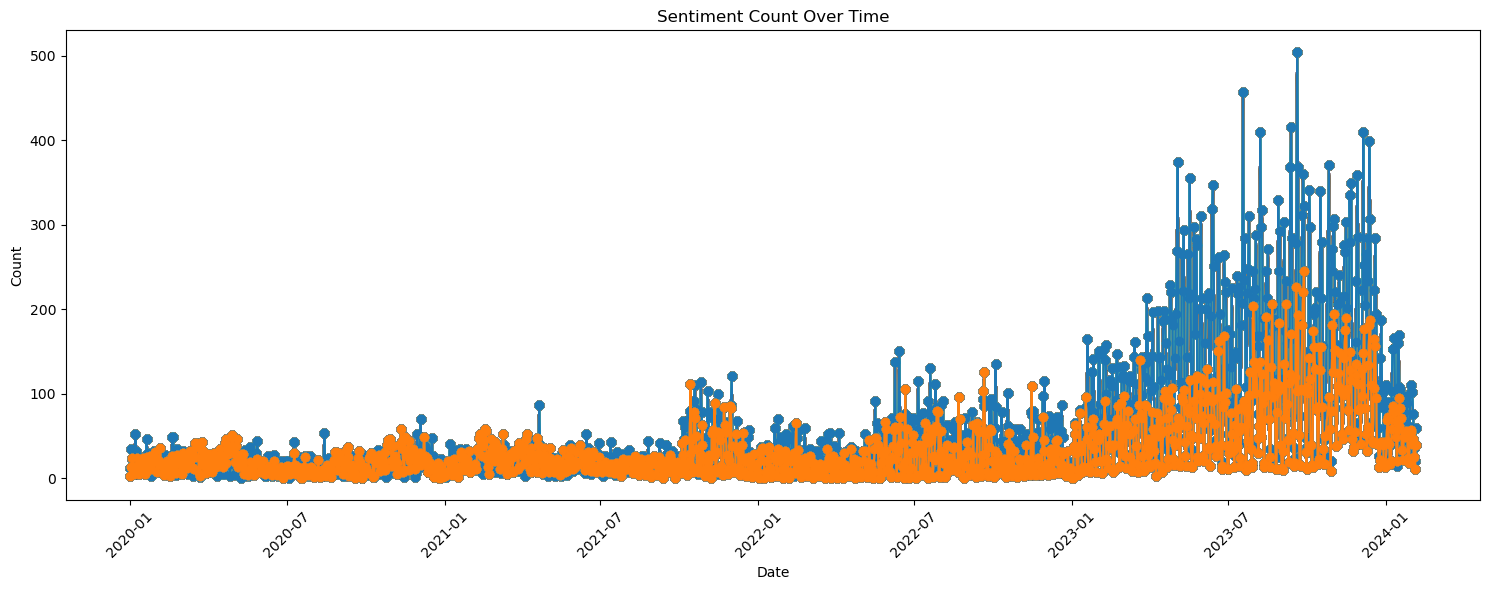

In [33]:
df_sentiment['count'] = 1
df_sentiment_grouped = df_sentiment.groupby(['date', 'sentiment_model_cat_text']).count().unstack(fill_value=0)
df_sentiment_grouped.columns = df_sentiment_grouped.columns.droplevel()  # Drop the multi-index on columns

plt.figure(figsize=(15, 6))
for sentiment in df_sentiment_grouped.columns:
    plt.plot(df_sentiment_grouped.index, df_sentiment_grouped[sentiment], label=sentiment, marker='o')

plt.title('Sentiment Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
## Positive

In [11]:
all_per_pos = [person for sublist in df_pos['Persons'].str.split(', ').tolist() for person in sublist if person]
per_counts_pos = Counter(all_per_pos)
top_10_per_pos = per_counts_pos.most_common(10)

print(top_10_per_pos)

[('Sam Altman', 3111), ('Biden', 3018), ('Elon Musk', 2050), ('Altman', 1572), ('Joe Biden', 1572), ('Bard', 1509), ('ChatGPT', 1342), ('Beatles', 1298), ('Taylor Swift', 1286), ('Instagram', 1248)]


In [12]:
all_org_pos = [org for sublist in df_pos['Organizations'].str.split(', ').tolist() for org in sublist if org]
org_counts_pos = Counter(all_org_pos)
top_10_org_pos = org_counts_pos.most_common(10)

print(top_10_org_pos)

[('AI', 74557), ('Gray Media Group', 20090), ('Google', 13370), ('Microsoft', 12864), ('Gray Television Inc', 12268), ('IBM', 8742), ('intelligenceA Gray Media Group Inc Station', 5936), ('Apple', 4991), ('Amazon', 4970), ('Artificial Intelligence', 4896)]


In [13]:
## Negative

In [14]:
all_per_neg = [person for sublist in df_neg['Persons'].str.split(', ').tolist() for person in sublist if person]
per_counts_neg = Counter(all_per_neg)
top_10_per_neg = per_counts_neg.most_common(10)

print(top_10_per_neg)

[('Sam Altman', 7703), ('Biden', 5862), ('Elon Musk', 5284), ('Altman', 3647), ('ChatGPT', 3503), ('Bard', 3138), ('Joe Biden', 3107), ('Musk', 2876), ('Taylor Swift', 2680), ('Trump', 2540)]


In [15]:
all_org_neg = [org for sublist in df_neg['Organizations'].str.split(', ').tolist() for org in sublist if org]
org_counts_neg = Counter(all_org_neg)
top_10_org_neg = org_counts_neg.most_common(10)

print(top_10_org_neg)

[('AI', 175082), ('Gray Media Group', 41070), ('Google', 29057), ('Microsoft', 26834), ('Gray Television Inc', 25142), ('Amazon', 14416), ('intelligenceA Gray Media Group Inc Station', 11966), ('AIgenerated', 11810), ('IBM', 10827), ('GPT', 10488)]


In [52]:
## impact of people over time

In [16]:
def ploting_person_org(df, col, search):
    df_filter = df[df[col].str.contains(search)]
    df_filter_count = df_filter.groupby('date').size().reset_index(name='count')

    plt.figure(figsize=(20,6))
    plt.plot(df_filter_count['date'], df_filter_count['count'], marker='o')
    plt.title(f'Count of {search} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

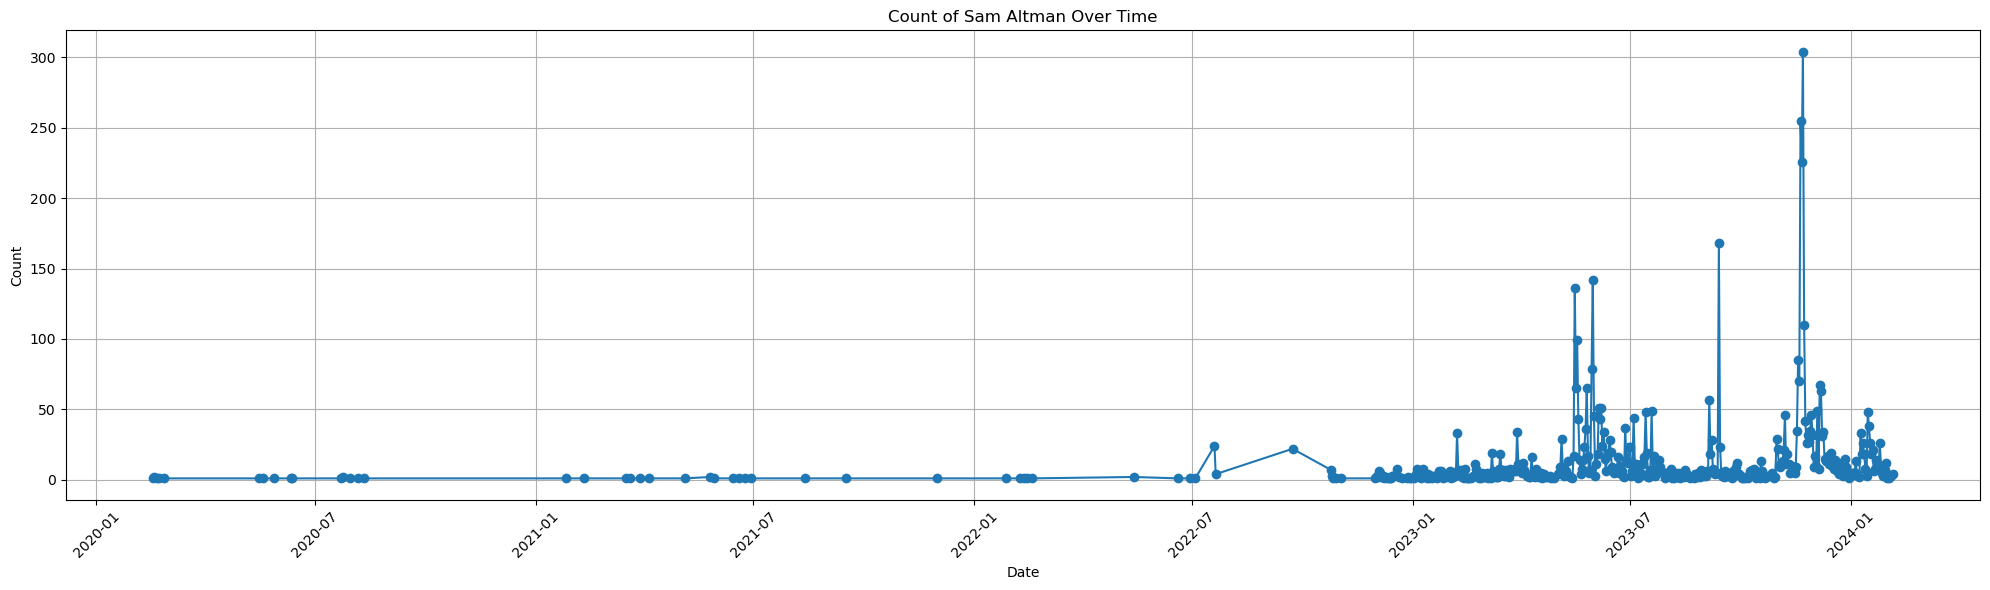

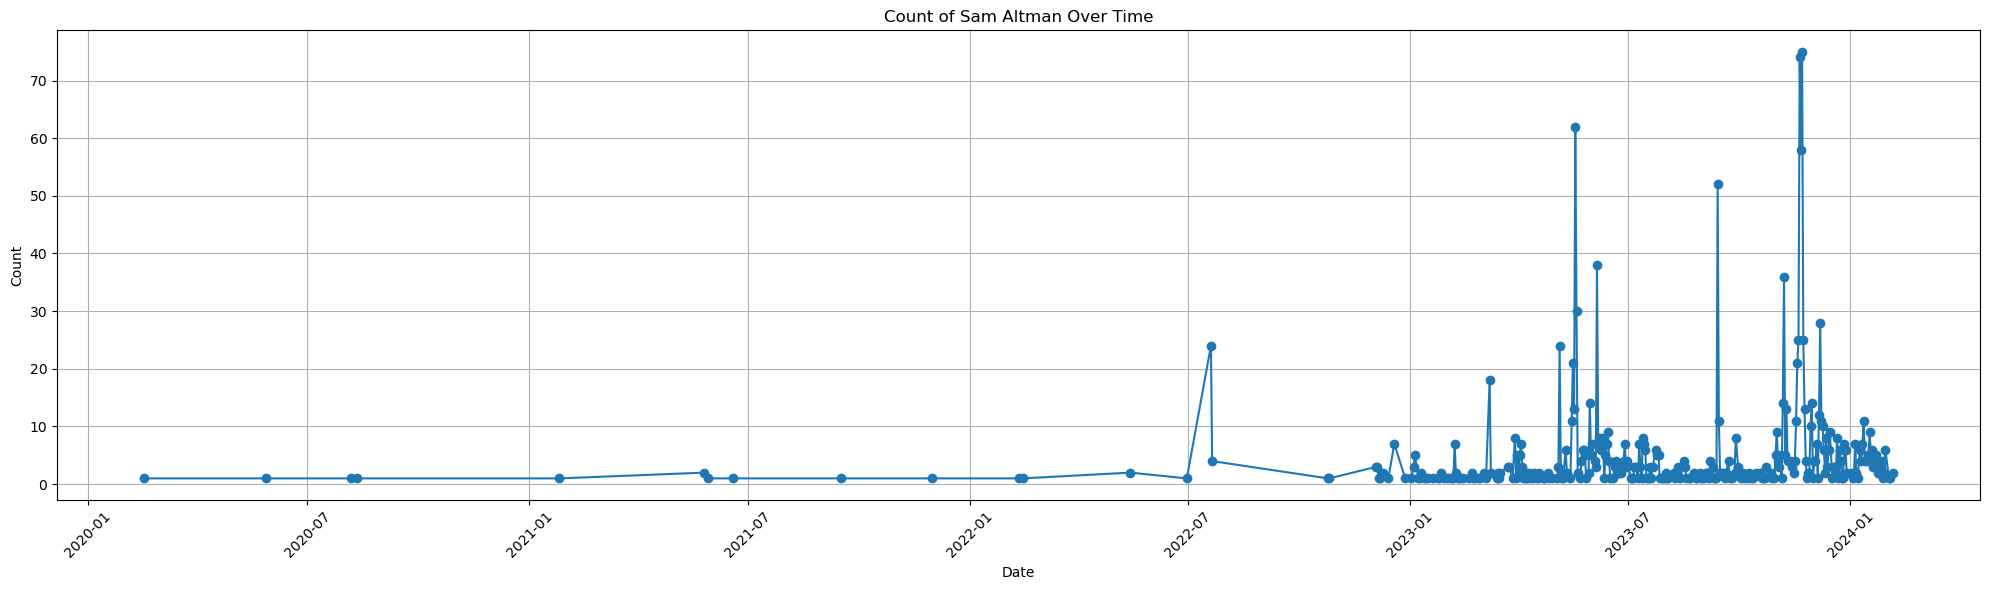

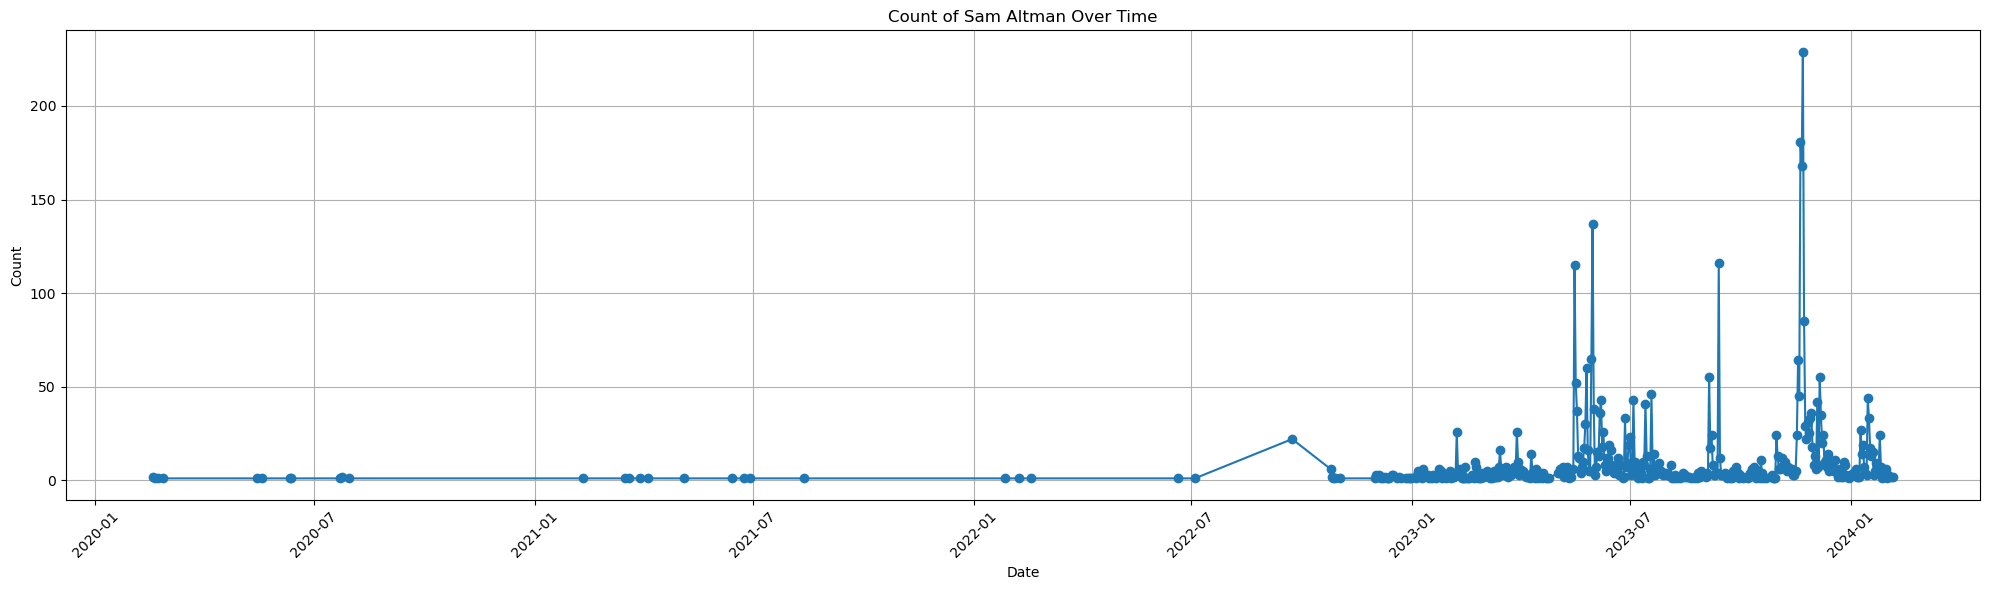

In [17]:
for dfs in [df_sentiment, df_pos, df_neg]:
    ploting_person_org(dfs,'Persons', 'Sam Altman')

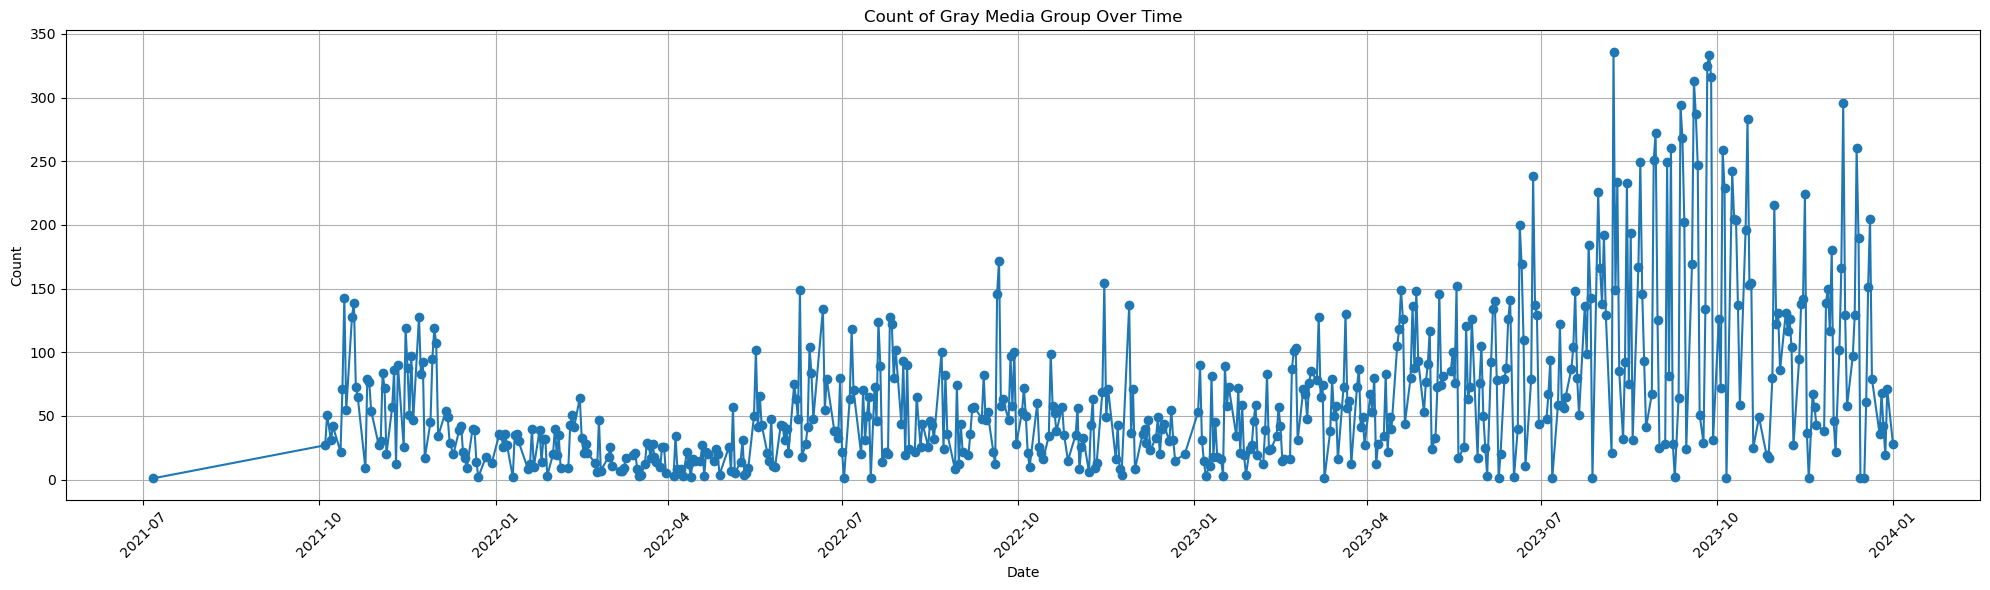

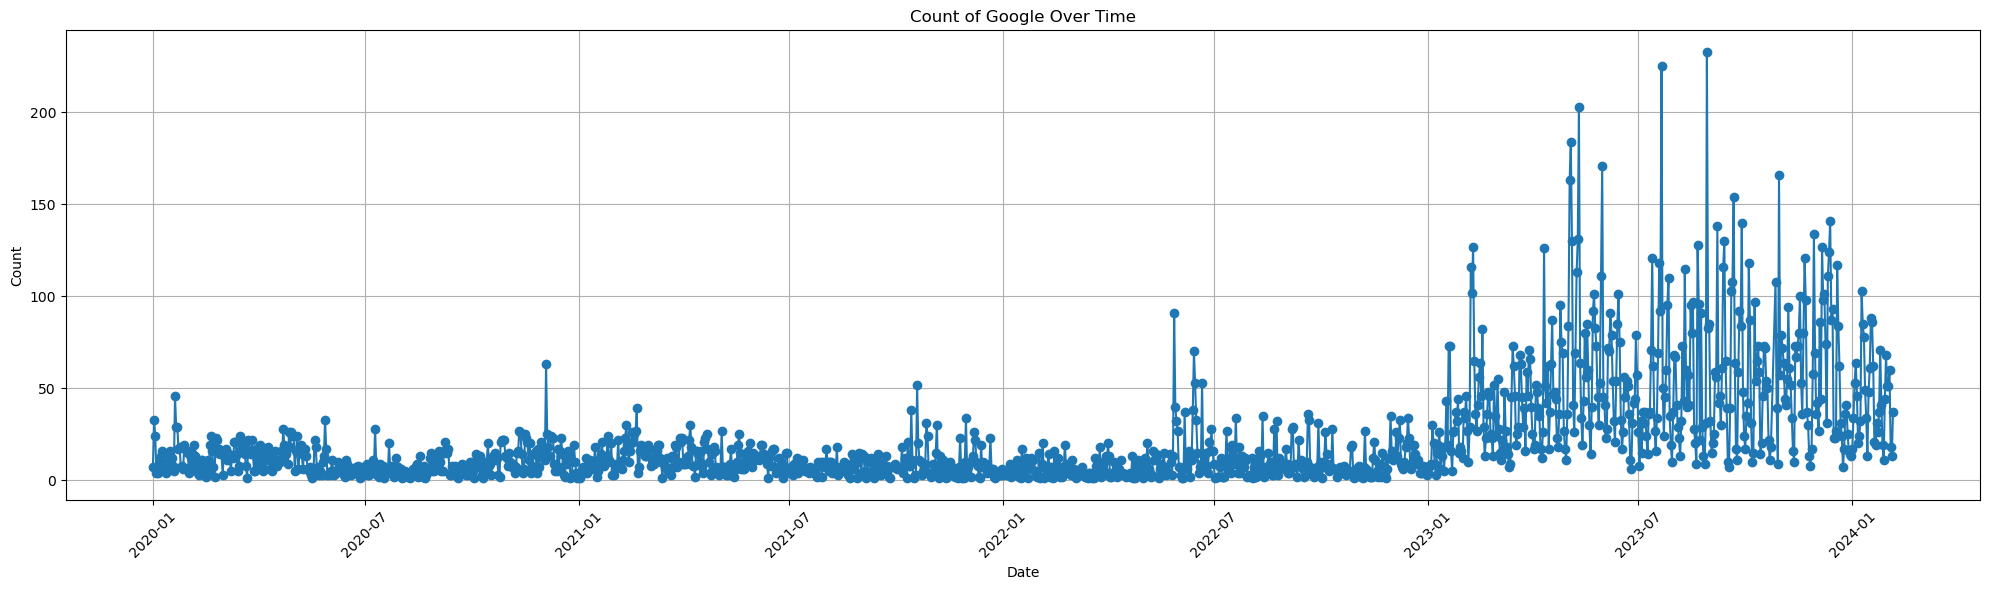

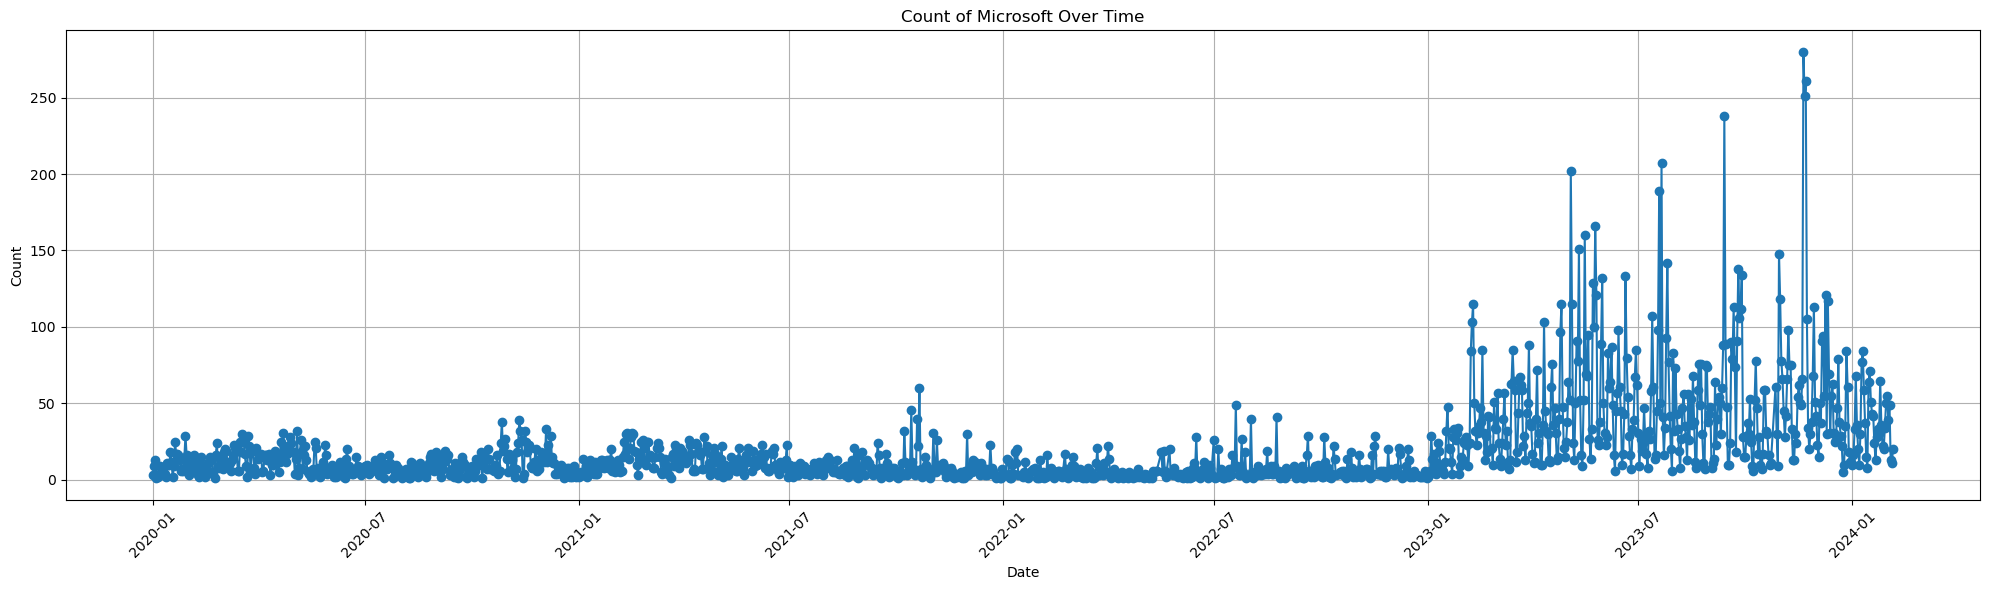

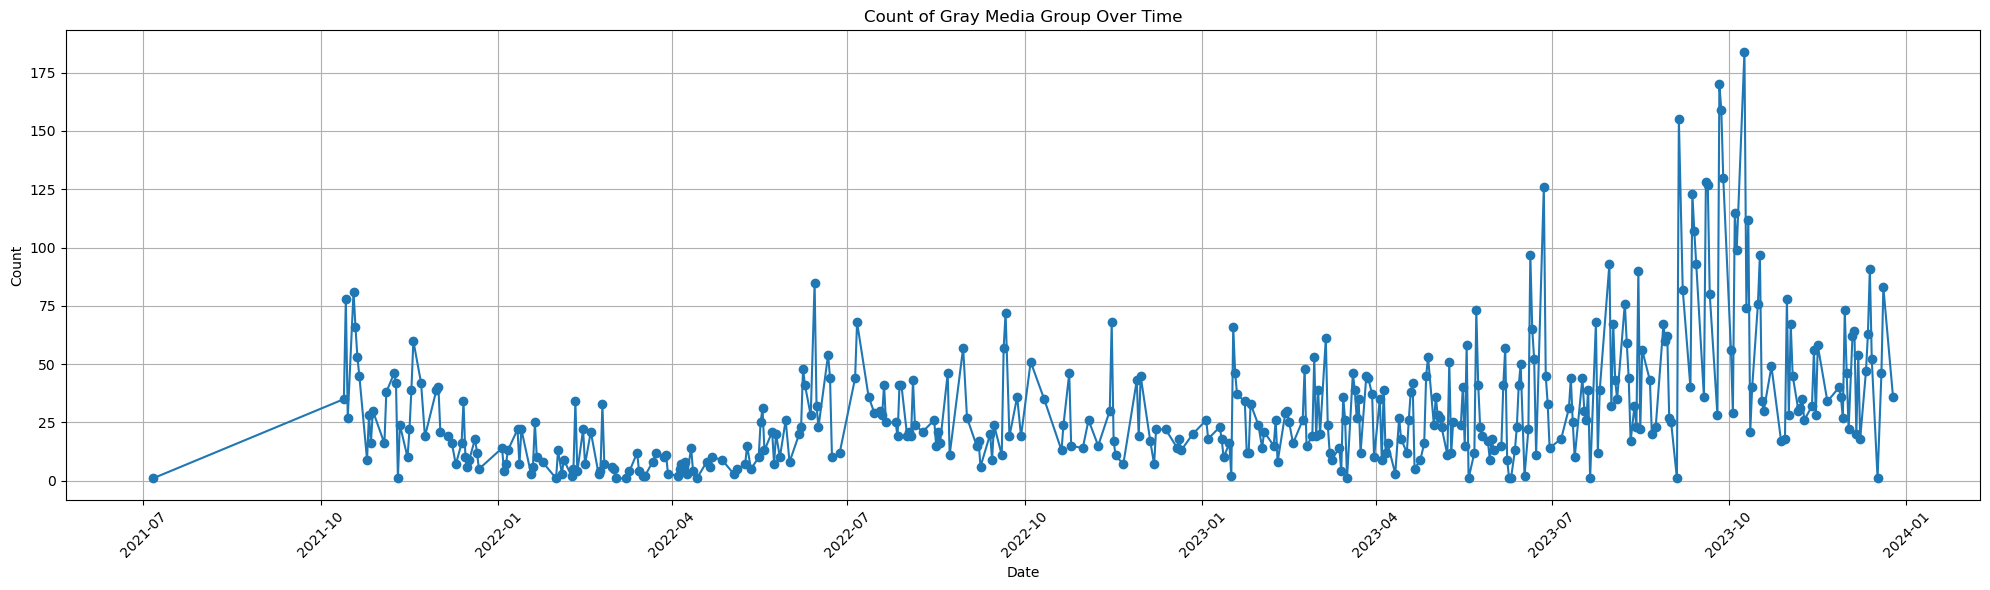

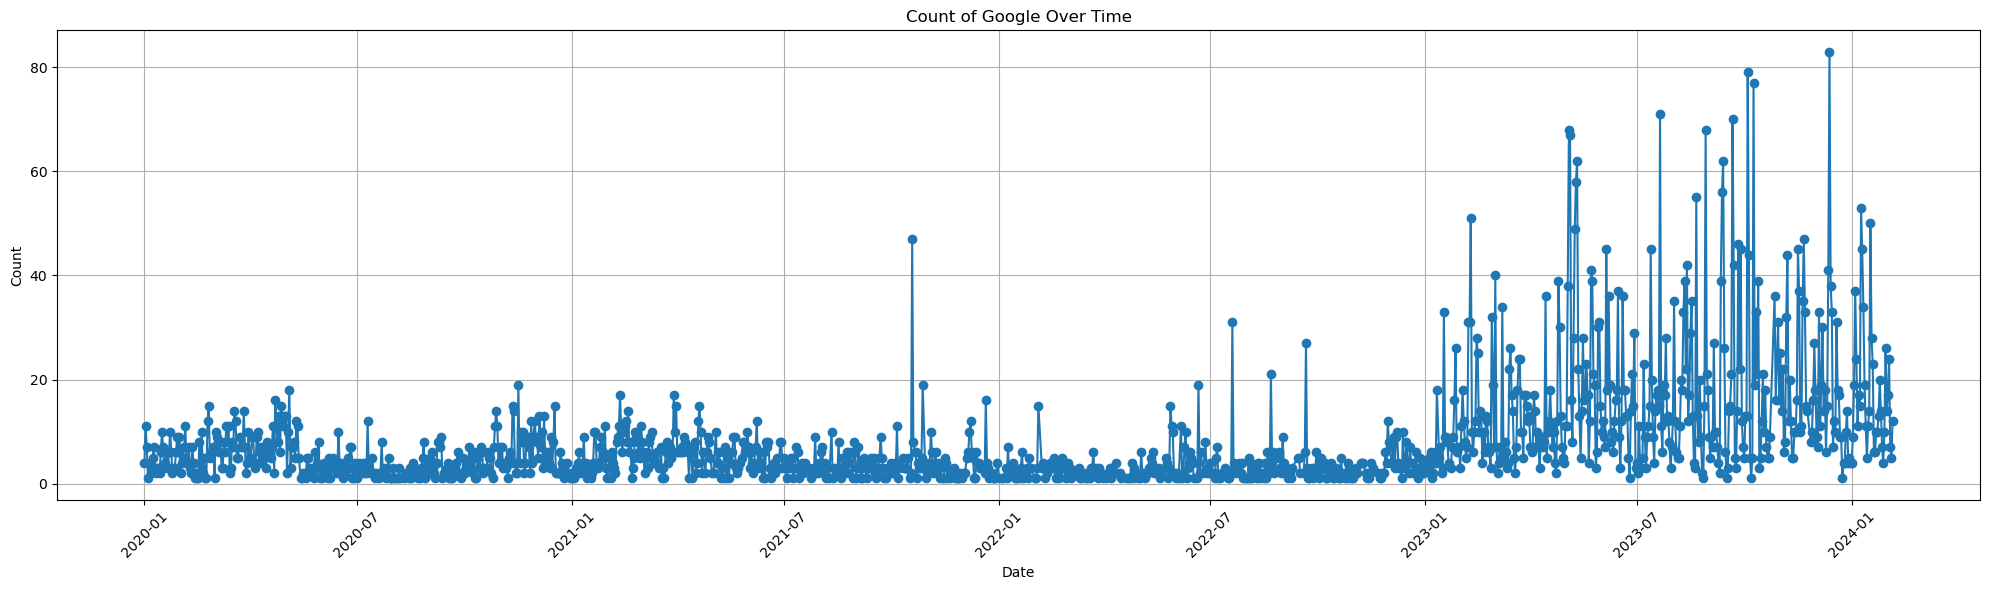

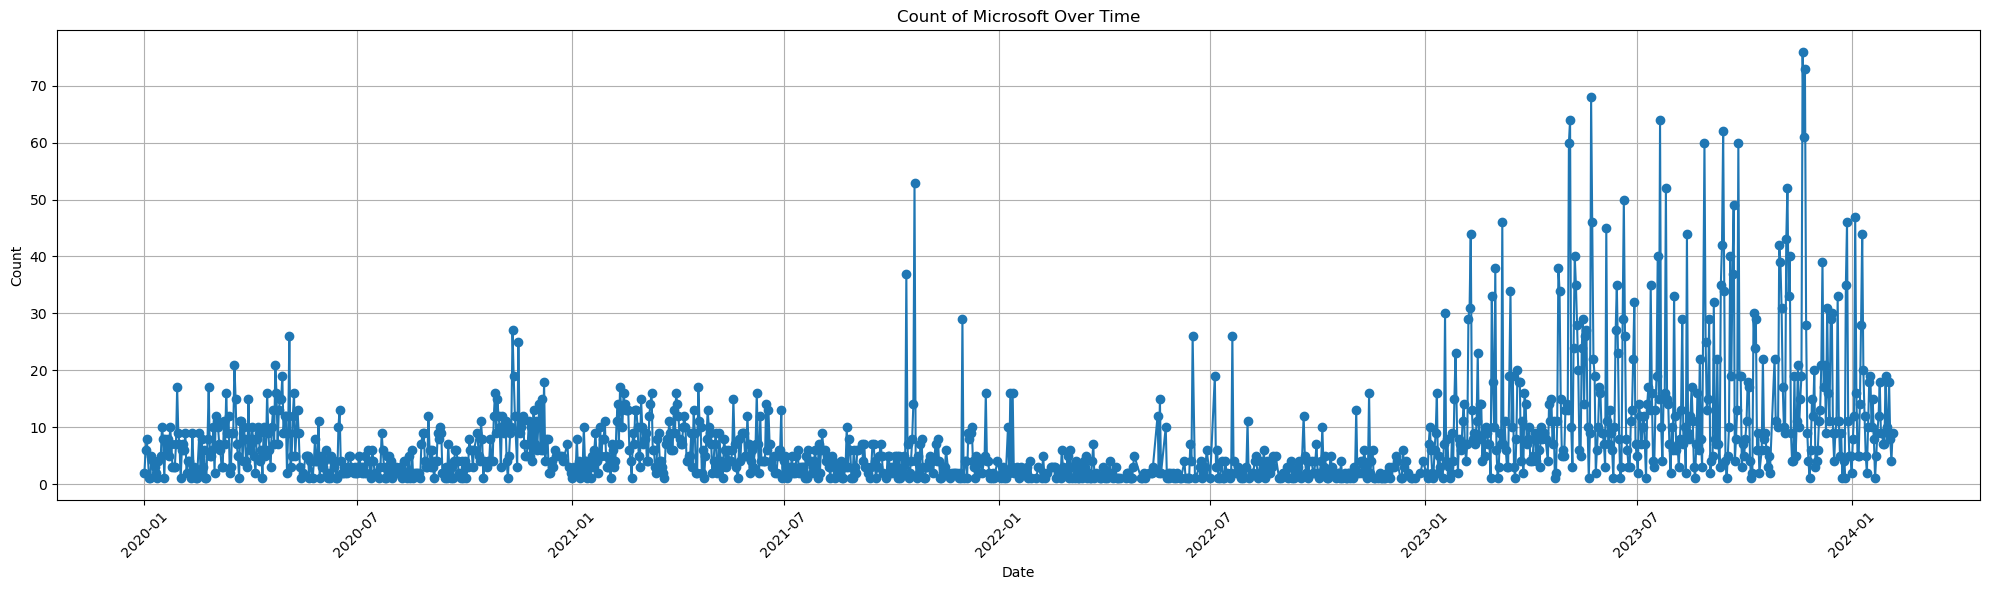

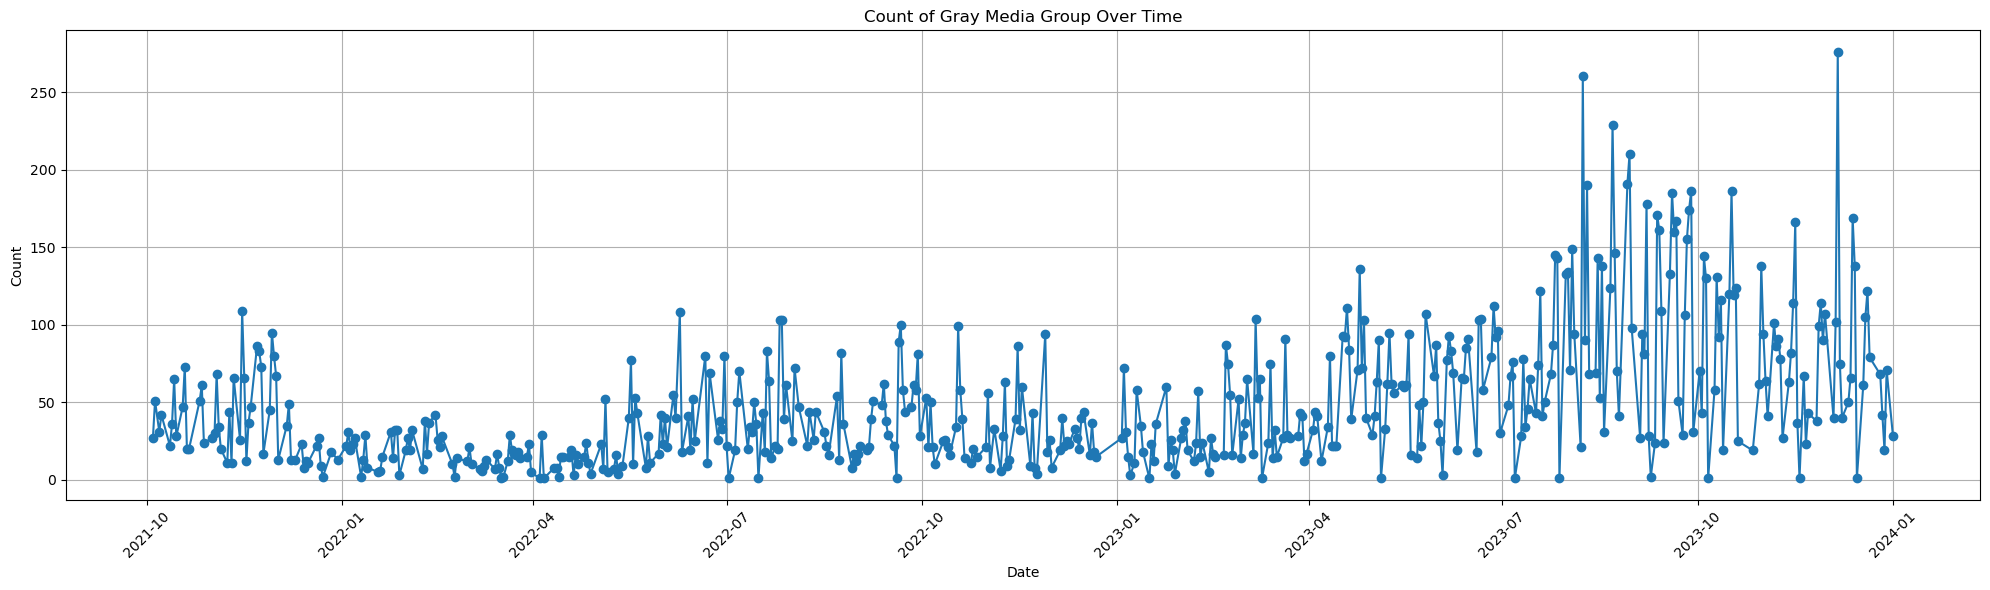

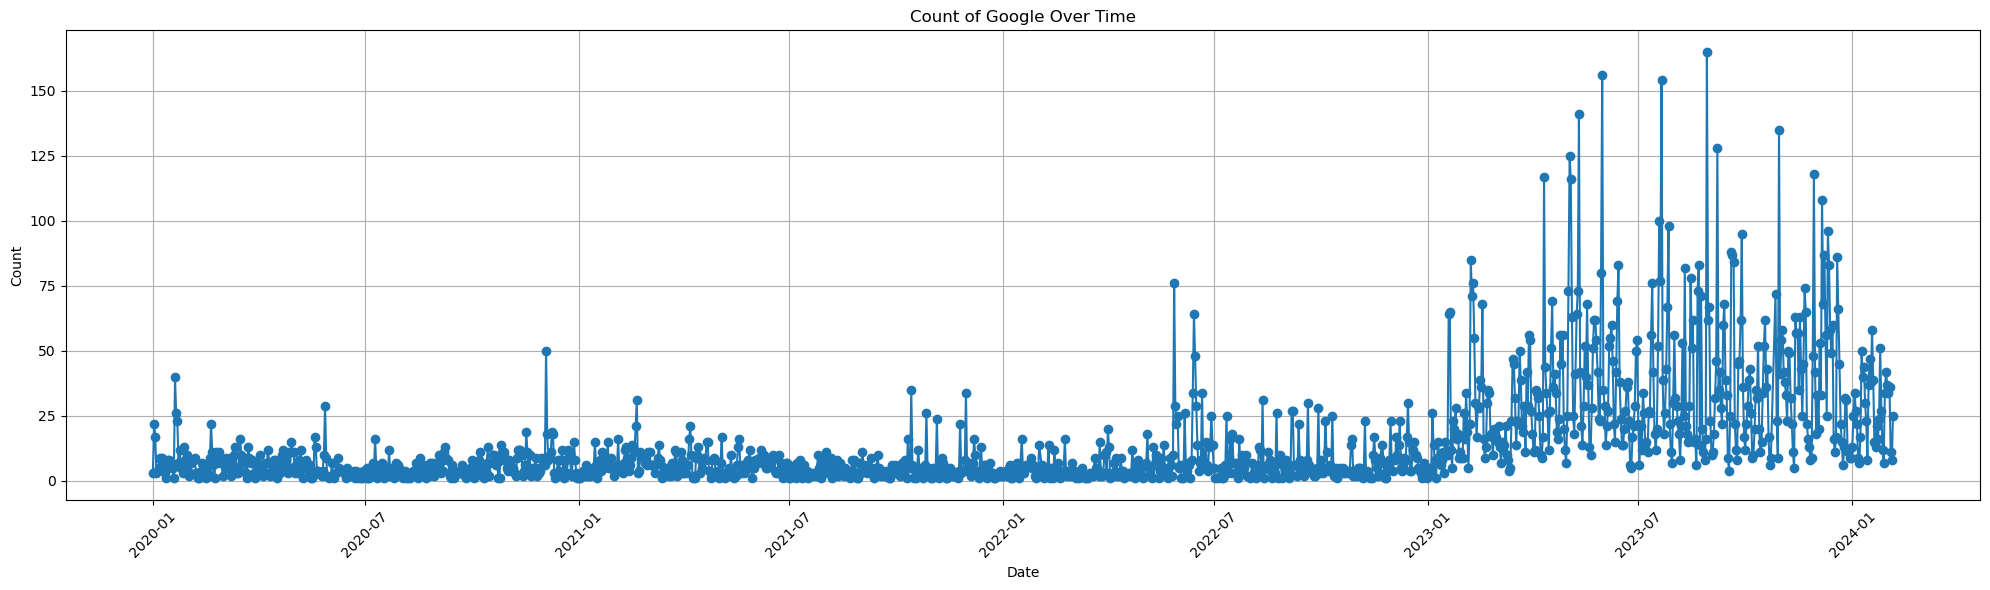

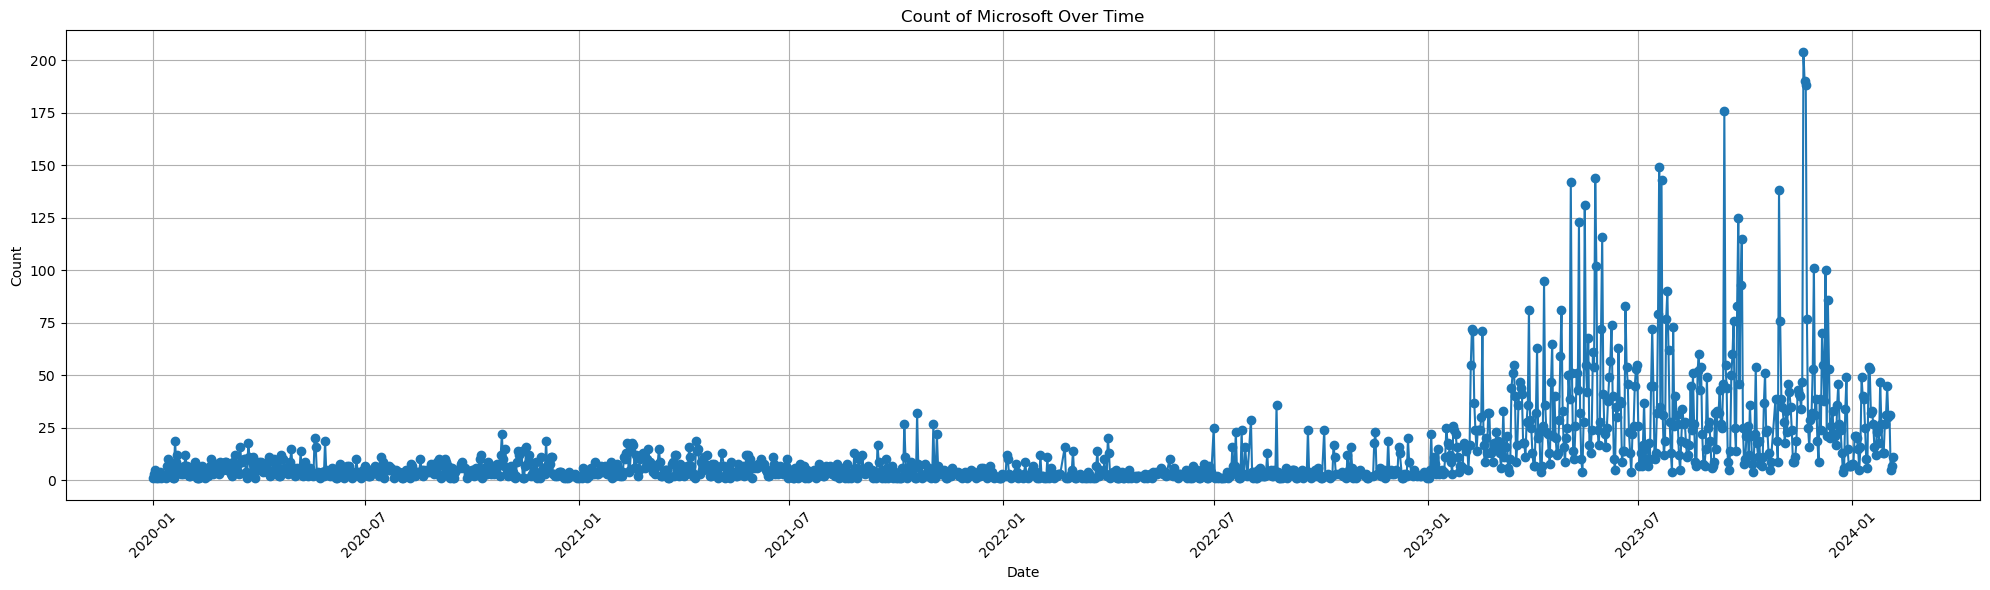

In [18]:
for dfs in [df_sentiment, df_pos, df_neg]:
    ploting_person_org(dfs, 'Organizations', 'Gray Media Group')
    ploting_person_org(dfs, 'Organizations', 'Google')
    ploting_person_org(dfs, 'Organizations', 'Microsoft')

In [ ]:
# Identifying industry

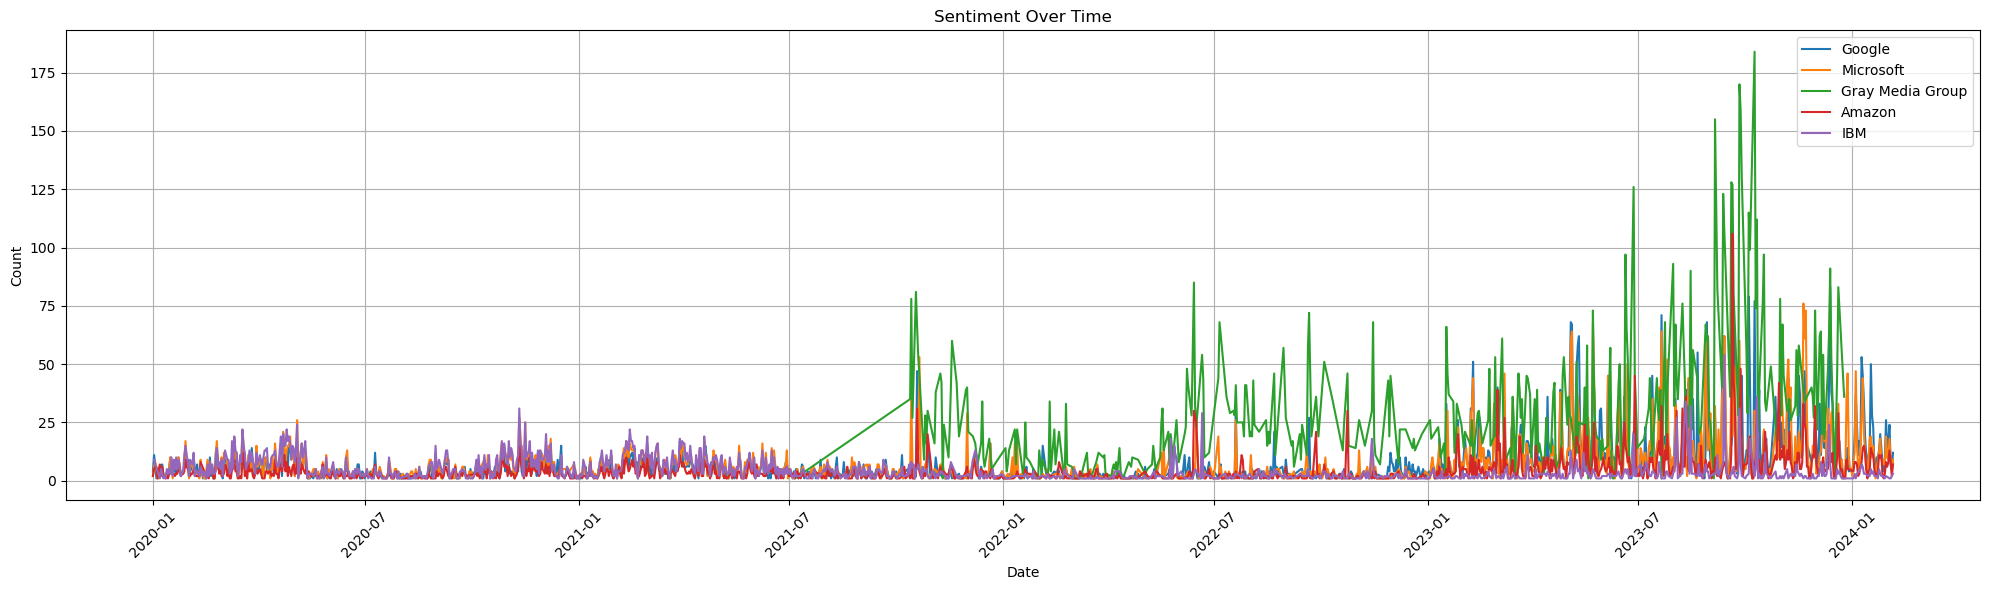

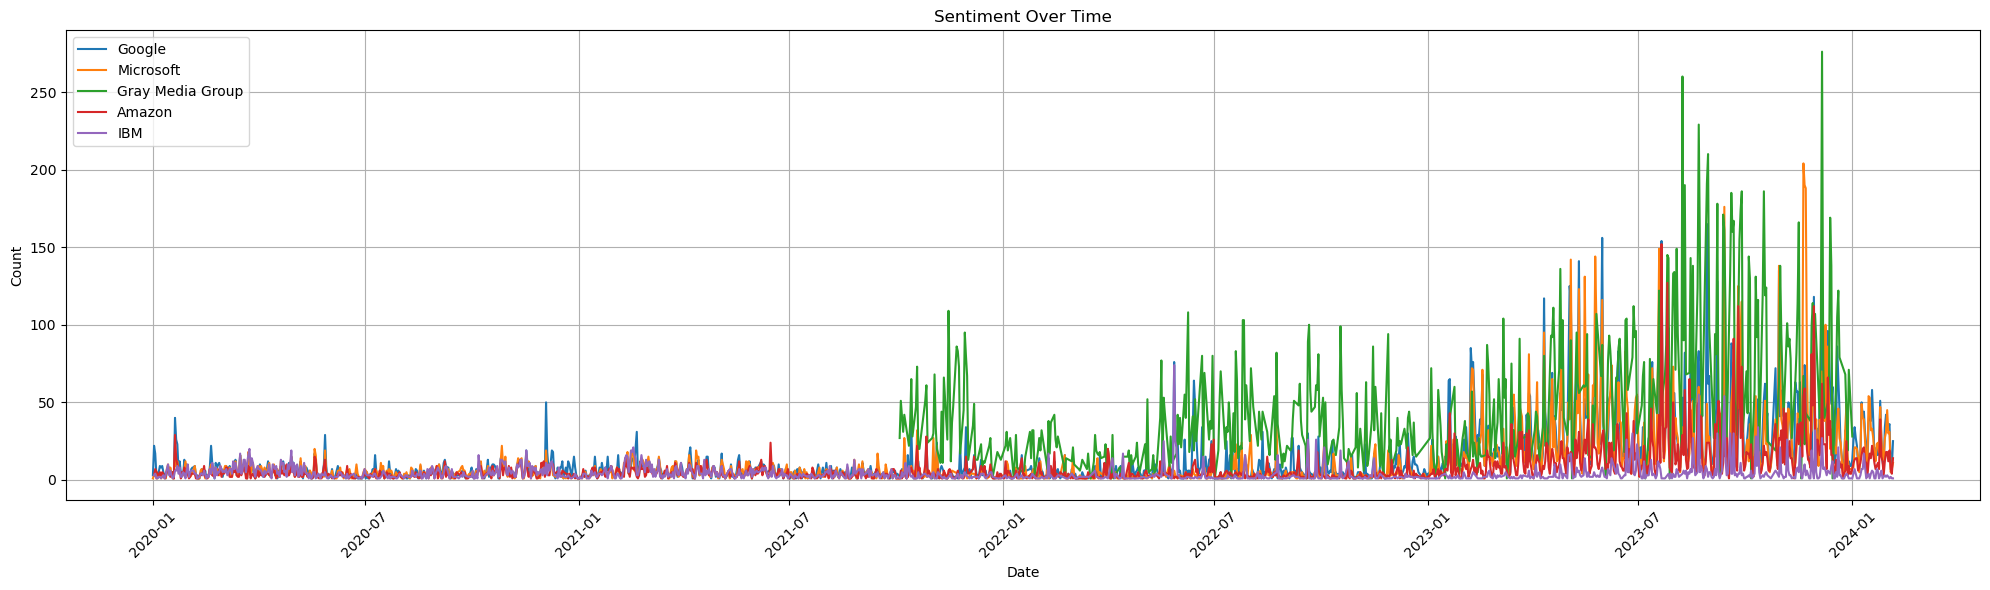

In [24]:
import matplotlib.pyplot as plt

def plot_multiple_search_terms(df, col, searches):
    plt.figure(figsize=(20,6))
    
    for search in searches:
        df_filter = df[df[col].str.contains(search, na=False)]
        df_filter_count = df_filter.groupby('date').size().reset_index(name='count')
        plt.plot(df_filter_count['date'], df_filter_count['count'], label=search)
    
    plt.title('Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example searches
search_terms = ['Google', 'Microsoft', 'Gray Media Group', 'Amazon', 'IBM']

# Assuming df_sentiment, df_pos, and df_neg are your DataFrames and they all have a 'date' and 'Organizations' column
for dfs in [df_pos, df_neg]:
    plot_multiple_search_terms(dfs, 'Organizations', search_terms)


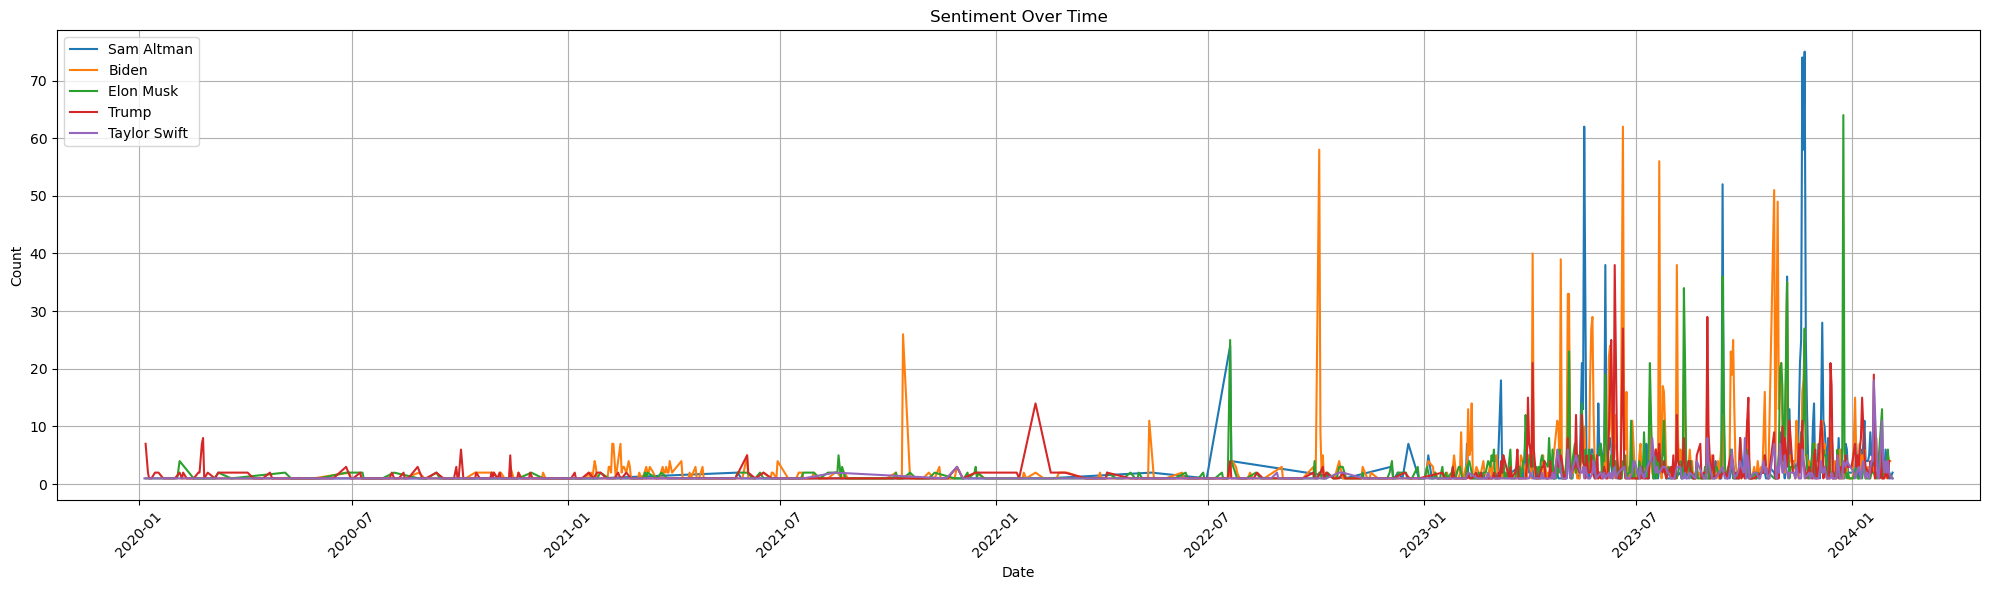

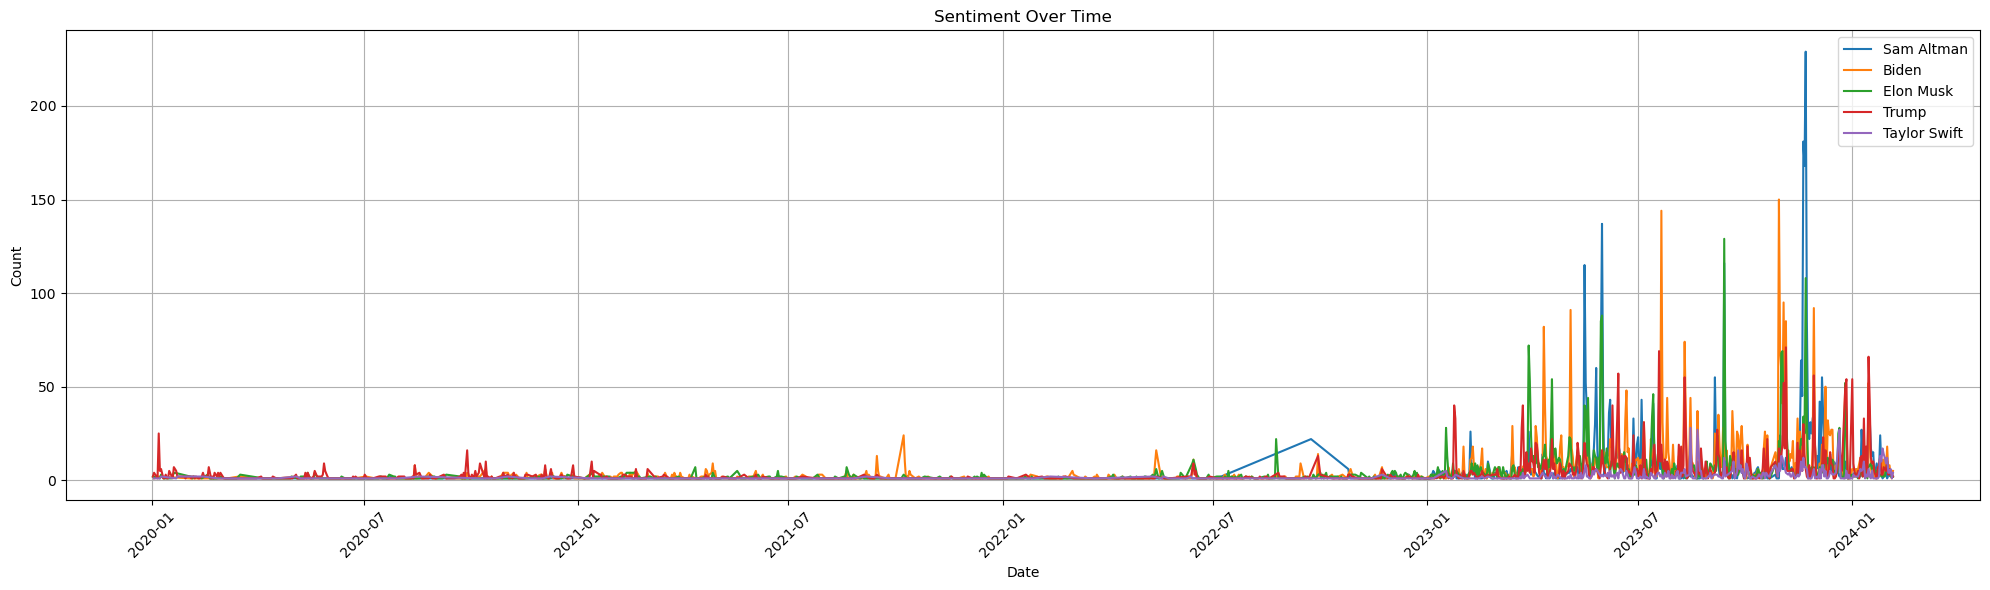

In [25]:
import matplotlib.pyplot as plt

def plot_multiple_search_terms(df, col, searches):
    plt.figure(figsize=(20,6))
    
    for search in searches:
        df_filter = df[df[col].str.contains(search, na=False)]
        df_filter_count = df_filter.groupby('date').size().reset_index(name='count')
        plt.plot(df_filter_count['date'], df_filter_count['count'], label=search)
    
    plt.title('Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example searches
search_terms = ['Sam Altman', 'Biden', 'Elon Musk', 'Trump', 'Taylor Swift']

# Assuming df_sentiment, df_pos, and df_neg are your DataFrames and they all have a 'date' and 'Organizations' column
for dfs in [df_pos, df_neg]:
    plot_multiple_search_terms(dfs, 'Persons', search_terms)


In [11]:
inv = ['invest', 'investing', 'invested']

def count_inv_words(text):
    count = sum(text.lower().count(word) for word in inv)
    return count

df_sentiment['inv_count'] = df_sentiment['clean_text_no_ai'].apply(count_inv_words)

In [20]:
df_sentiment.head()

date                                     clean_title_v3  \
0  2020-02-26  LegalTech Artificial Intelligence Market  Tech...   
2  2020-03-13  Covid un messaggio dai ricercatori italiani ai...   
7  2021-02-25  MulticoreWare Inc Becomes CEVAs Trusted Partne...   
8  2022-10-06  Healthcare Artificial Intelligence Market Anal...   
9  2020-04-29  Artificial Intelligence As A Service Market Op...   

                                       clean_text_v5  \
0  LegalTech Artificial Intelligence Market Techn...   
2  Covid un messaggio dai ricercatori italiani ai...   
7  MulticoreWare Inc Becomes CEVAs Trusted Partne...   
8  Healthcare Artificial Intelligence Market Anal...   
9  Artificial Intelligence Service Market Opportu...   

                                    clean_text_no_ai  sentiment_model_text  \
0  legaltech  market  advancement future scope ca...                     1   
2  covid un messaggio d ricercatori italiani  col...                     1   
7  multicoreware inc becomes cevas trusted partne...                     0   
8  healthcare  market analysis forecast next year...                     1   
9   service market opportunities market analysis ...                     1   

  sentiment_model_cat_text  sentiment_model sentiment_model_cat  \
0                 Positive                1            Positive   
2                 Positive                0            Negative   
7                 Negative                0            Negative   
8                 Positive                0            Negative   
9                 Positive                0            Negative   

                                             Persons  \
0  Australis Galus, Agrident AllflexContact, UsIr...   
2  dai ricercatori italiani ai, Di la tua Tempo, ...   
7  Erez Natan, Soumendra Mohanty VicePresident Wo...   
8                                      Nidhi Bhawsar   
9                                    ForecastQiu Qiu   

                                       Organizations  \
0  LegalTech, Sony, Roche Diagnostics Veterinary ...   
2  stranieri AgoraVox Italia Accedi Partecipa, Ag...   
7  MulticoreWare Inc Becomes CEVAs Trusted Partne...   
8  Healthcare Artificial Intelligence Market Anal...   
9  Artificial Intelligence Service Market Opportu...   

                                           locations  inv_count  
0  Australis, US, United States, China, Japan, In...          0  
2  Italy, Italy, Italy, Peoples Republic China Fi...          2  
7                         SAN JOSE CalifBUSINESS Inc          1  
8  RD, India, China, Canada, Mexico, Brazil, Arge...          0  
9  China, Malaysia, Japan, Philippines, Korea, Th...          0

In [12]:
inv_df = df_sentiment[df_sentiment['inv_count'] != 0]
exploded_df = inv_df.assign(organization=inv_df['Organizations'].str.split(', ')).explode('organization')
org_inv_count = exploded_df.groupby('organization')['inv_count'].sum().sort_values(ascending=False)

In [13]:
df_neg = df_sentiment[df_sentiment['sentiment_model_cat']=='Negative']
df_pos = df_sentiment[df_sentiment['sentiment_model_cat']=='Positive']

In [18]:
df_pos.shape, df_neg.shape

((44097, 12), (87472, 12))

In [15]:
inv_df_pos = df_pos[df_pos['inv_count'] != 0]
exploded_df_pos = inv_df_pos.assign(organization=inv_df_pos['Organizations'].str.split(', ')).explode('organization')
org_inv_count_pos = exploded_df_pos.groupby('organization')['inv_count'].sum().sort_values(ascending=False)

In [16]:
inv_df_neg = df_neg[df_neg['inv_count'] != 0]
exploded_df_neg = inv_df_neg.assign(organization=inv_df_neg['Organizations'].str.split(', ')).explode('organization')
org_inv_count_neg = exploded_df_neg.groupby('organization')['inv_count'].sum().sort_values(ascending=False)

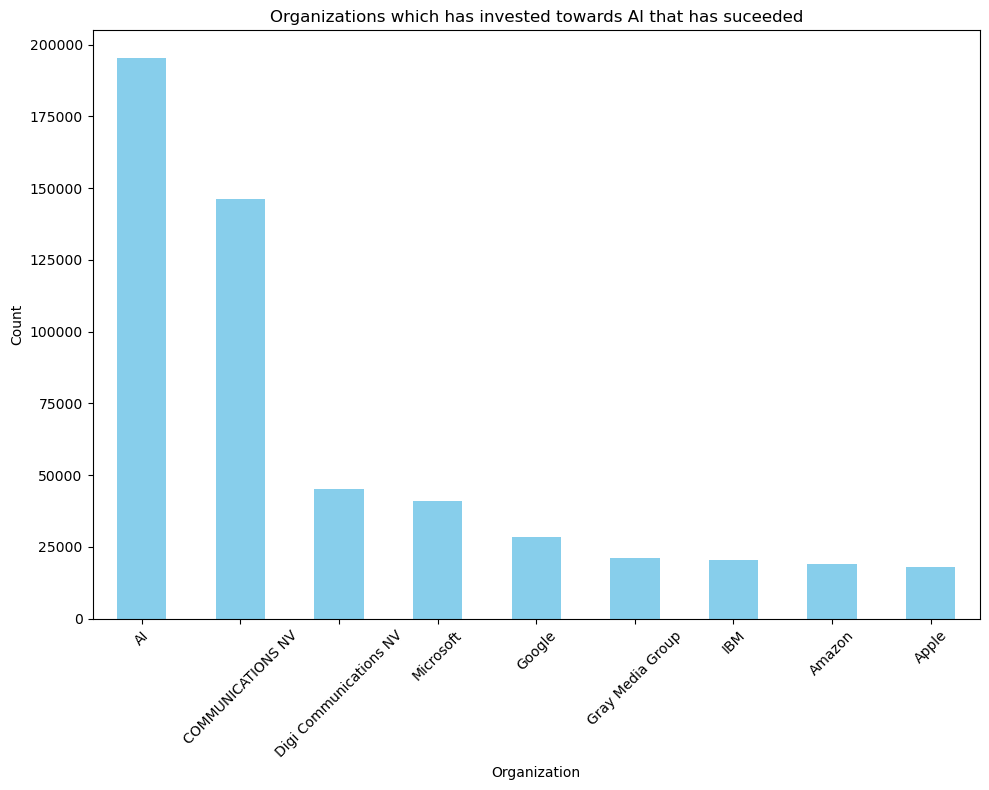

In [23]:
top_12_orgs_pos = org_inv_count_pos.head(9)

plt.figure(figsize=(10, 8))
top_12_orgs_pos.plot(kind='bar', color='skyblue')
plt.title('Organizations which has invested towards AI that has suceeded')
plt.xlabel('Organization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
ai_keywords = ['Data Science', 'data science', 'DATA SCIENCE','AI', 'ai', 'artificial intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'ML', 'NLP', 
            'Artificial General Intelligence','Chatbots', 'AI Marketplaces', 'Intelligent Applications', 
           'Augmented Intelligence', 'Decision Intelligence', 'AI Cloud Services', 'cloud services', 'GPU Accelerators', 'Computer Vision','Deep Neural Network',
           'Deep Learning','Cognitive Computing','Autonomous Vehicles','Knowledge Graphs', 'Responsible AI', 'Machine Customers', 'Decision Intelligence', 'Autonomous Vehicles',
           'Human-Centered AI', 'AI Governance', 'Natural Language Processing', 'Machine Learning', 'Smart Robots', 'Operational AI Systems' , 'Data-Centric AI', 'AI TRiSM', 'Generative AI',
           'Responsible AI']

### Overall

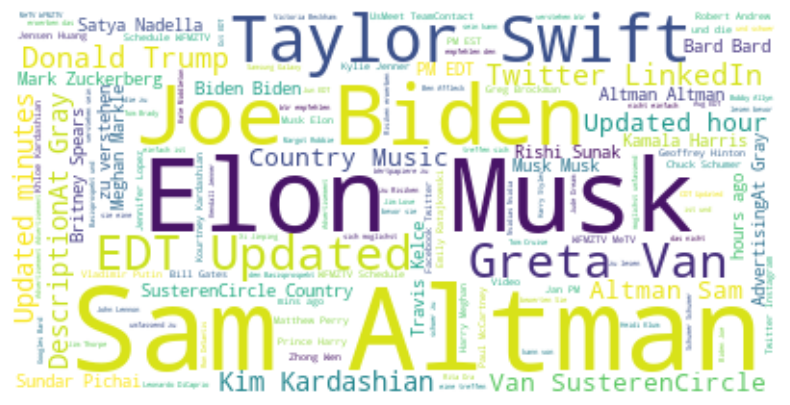

In [26]:
person_text = " ".join(entities for entities in df_sentiment['Persons'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(person_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

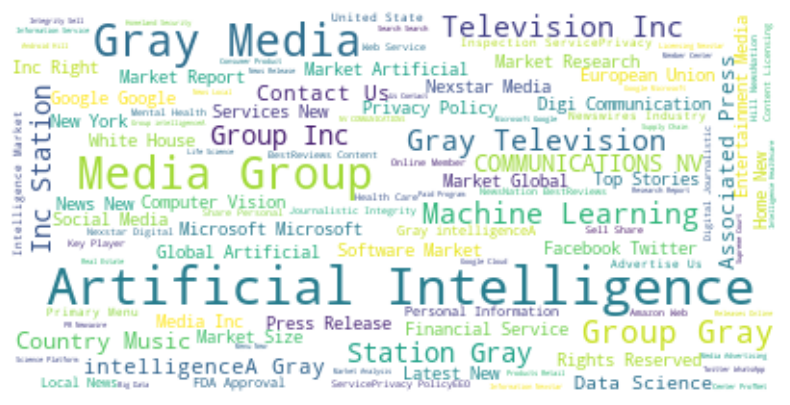

In [27]:
org_text = " ".join(entities for entities in df_sentiment['Organizations'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(org_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

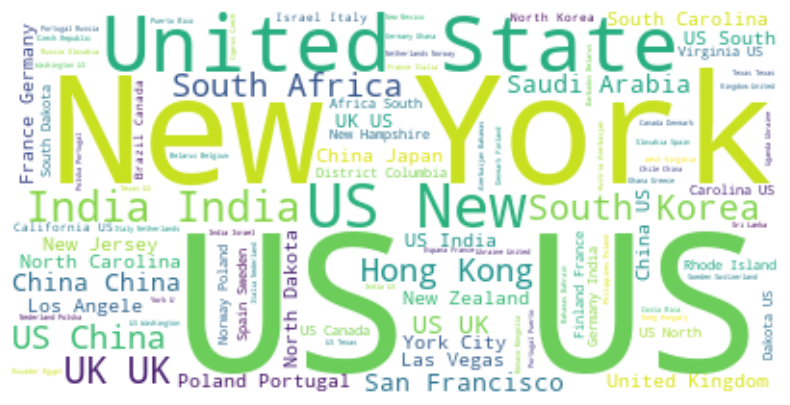

In [30]:
loc_text = " ".join(entities for entities in df_sentiment['locations'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(loc_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Positive

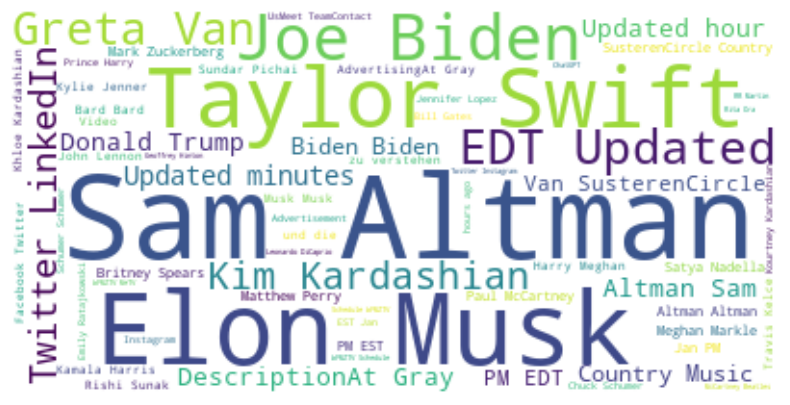

In [30]:
person_pos_text = " ".join(entities for entities in df_pos['Persons'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(person_pos_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

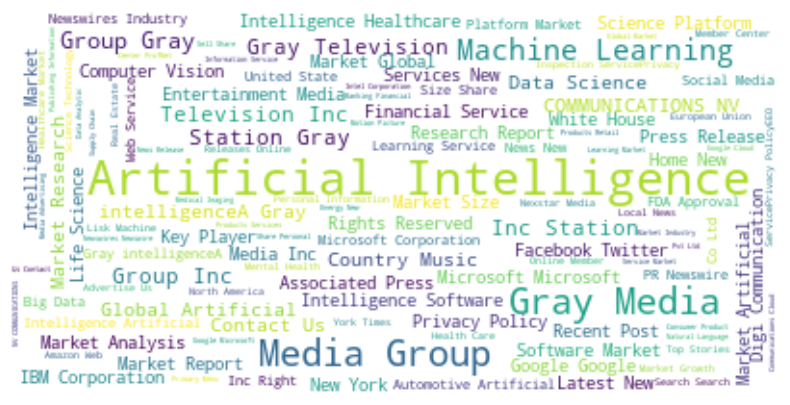

In [31]:
org_pos_text = " ".join(entities for entities in df_pos['Organizations'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(org_pos_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative

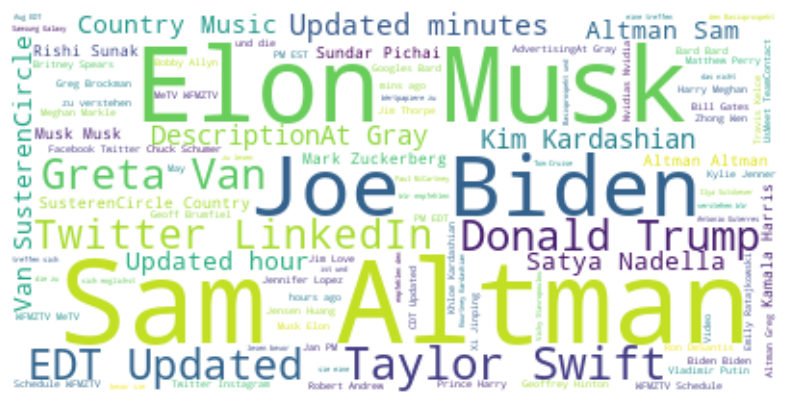

In [32]:
person_neg_text = " ".join(entities for entities in df_neg['Persons'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(person_neg_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

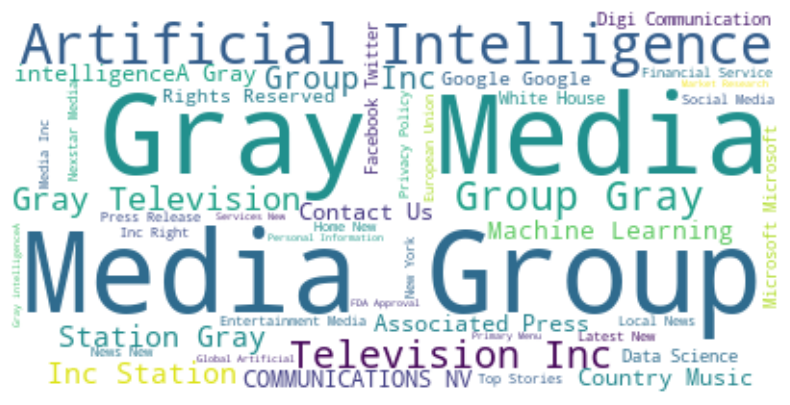

In [33]:
org_neg_text = " ".join(entities for entities in df_neg['Organizations'])

stopwords = set(STOPWORDS)
stopwords.update(ai_keywords)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(org_neg_text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### new technologies and AI solutions

In [8]:
new_tech = [
    "artificial intelligence",
    "machine learning",
    "deep learning",
    "natural language processing",
    "computer vision",
    "robotic process automation",
    "edge computing",
    "quantum computing",
    "blockchain",
    "internet of things",
    "5G technology",
    "augmented reality",
    "virtual reality",
    "cybersecurity",
    "cloud computing",
    "autonomous vehicles",
    "smart cities",
    "biotechnology",
    "renewable energy technology"
]